<a href="https://colab.research.google.com/github/so-da-sea/star_tech_industries/blob/master/Project_1_Template_Daigle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Startup Lending Model (Probabalistic Loan Pricing)

- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model

## Setup

Setup for the later calculations are here. The necessary packages are imported.

In [1]:
!pip install numpy-financial -q

In [2]:
from dataclasses import dataclass
import pandas as pd
%matplotlib inline
import numpy as np #supports large arrays
import numpy_financial as npf #supports fin calcs
import matplotlib.pyplot as plt #plotting
from tqdm.notebook import tqdm #progress bar
import random #pseudo-random number generator

## Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [3]:
@dataclass
class ModelInputs:
    price_machine: float = 1000000
    loan_life: int = 5
    initial_default: float = 0.3
    default_decay: float = 0.9
    final_default: float = 0.4
    recovery_rate: float = 0.4
    num_iterations: int = 1000

model_data = ModelInputs()
#creating the class and setting default inputs for model_data

model_data

ModelInputs(price_machine=1000000, loan_life=5, initial_default=0.3, default_decay=0.9, final_default=0.4, recovery_rate=0.4, num_iterations=1000)

STEPS:
*   yearly interest rate
*   yearly cash flows (append if default does/does not occur)
*   discrete simulation
*   expected IRR and visualizations


### Yearly Default Rates

The default rates over time evolves by the following equation:

$$
d_t = \begin{cases}
d_1 & t = 1 \\
d_{t-1} d_d & 1 < t < n\\
d_n & t = n \\
0 & t > n
\end{cases}
$$

Where:

- $t$: The current year, starting with 1 for the first loan payment
- $d_t$: The default rate for year $t$
- $d_1$: The initial, first year default rate
- $d_d$: The decay rate of the probability of default
- $d_n$: The final year probability of default
- $n$: The life of the loan

In other words, there is an initial given probability of default in the first year, then it decays at the decay rate each year, up until the final repayment year which has a separate default probability because of the larger loan payment to pay back the principal.

By solving the middle time-series equation, we can create an equation which does not depend on the prior year:

$$d_2 = d_1 d_d$$
$$d_3 = d_2 d_d$$
$$d_3 = d_1 d_d ^ 2$$
$$d_4 = d_3 d_d$$
$$d_4 = d_1 d_d ^ 3$$

Following this pattern, therefore:

$$d_t = d_1 d_d^{t - 1}$$

And so the overall equation becomes:


$$
d_t = \begin{cases}
d_1 & t = 1\\
d_1 d_d^{t - 1} & 1 < t < n\\
d_n & t = n \\
0 & t > n
\end{cases}
$$

In [4]:
def calc_annual_int_rate(principal,rate):
  """Calculates annual int payment"""
  return principal*rate


In [5]:
def calc_CF(data, interest_rate, default_year):
  cash_flows= [-data.price_machine] #initial outflow for the bank
 #calc initial payments
  for year in range(1, data.loan_life):
    if year < default_year:
      #each yrs payment
      cash_flows.append(data.price_machine * interest_rate)
    elif year == default_year:
      #cash_flows.append(0)
      break #exits for loop

  #handle the recovery payment
  if default_year <= data.loan_life:
    cash_flows.extend([0,0]) #adds two yrs of no CF for the bankruptcy period
    cash_flows.append(data.recovery_rate*data.price_machine)

#default deos not occur within the loan life
  else:
    cash_flows.append(data.price_machine * (1+ interest_rate))

  return cash_flows

In [6]:
#example w default params
example_interest_rate = .35
example_default_year=6
example_cash_flows = calc_CF(model_data, example_interest_rate, example_default_year)

example_cash_flows

[-1000000, 350000.0, 350000.0, 350000.0, 350000.0, 1350000.0]

In [24]:
#probability of default
def default_prob_at_year(data,year):
  """
  calc prob of default at a given year
  """
  #finding where in the timeline you are defaulting first
  if year ==1:
    return data.initial_default
  elif year< data.loan_life:
    return data.initial_default *(data.default_decay ** (year-1))
  else: #for the final year
    return data.final_default

In [8]:
#incorproating internal randomness
#most complex function
def get_rand_default_year(data):
  """
  returns a random yr of default
  """
  probs= [default_prob_at_year(data,year)for year in range (1, data.loan_life)]
  probs.append(data.final_default)
  cumulative_probs= np.cumsum(probs)
  rand_val= random.uniform(0,1)

  #for loop to work through each yr of the loan
  for year, cum_prob in enumerate(cumulative_probs,1): #takes two vals and compares them
    if rand_val <= cum_prob: #if rand var is less than cum_prob of default
      return year
    else:
      return data.loan_life #indicate no default


In [33]:
from typing import List

#simulate loan scenarios

def simulate_loan_scenarios(
    data,
    interest_rates : List[float] ,
    loan_lives : List[float],
    initial_defaults : List[float]
    ):
  """
  get
  """

  # final output
  scenarios_results = []

  total_iterations= 27000

  #progress bar
  with tqdm(total=total_iterations, desc="Simulating Loan Scenarios") as pbar:

    # iterate all combinations
    for rate in interest_rates:
      for life in loan_lives:
        for initial_default in initial_defaults:

          #goal
          irrs=[]

          data.loan_life = life #update loan life per scenario
          data.initial_default = initial_default #updating
          interest_rate = rate

          # this is import to do 1000 times
          for _ in range(model_data.num_iterations):

              default_year = get_rand_default_year(data) #calling back to prev created function for a rand default yr
              cash_flows= calc_CF(data, interest_rate, default_year)

              try:
                irr = npf.irr(cash_flows)
                irrs.append(irr)
              except:
                  pass #skip iterations where IRR cannot be calculated
              finally:
                pbar.update(1)

          # get irr output for combination
          expected_irr = np.mean(irrs) if irrs else None

          # append irr to goal list
          scenarios_results.append({
              "interest rate":rate,
              "loan life": life,
              "initial deafult probability": initial_default,
              "expected IRR": expected_irr
          })
  return pd.DataFrame(scenarios_results)

In [34]:
#params
interest_rates = [.30,.35,.40]
loan_lives = [5,10,20]
initial_defaults = [.1,.2,.3]

In [35]:
model_data.num_interations = 1000

In [36]:
df_discrete = simulate_loan_scenarios (model_data, interest_rates, loan_lives, initial_defaults)

Simulating Loan Scenarios:   0%|          | 0/27000 [00:00<?, ?it/s]

In [37]:
df_discrete

,interest rate,loan life,initial deafult probability,expected IRR
0,0.30,5,0.1,0.116435
1,0.30,5,0.2,0.065291
2,0.30,5,0.3,0.023710
3,0.30,10,0.1,0.215944
4,0.30,10,0.2,0.172094
5,0.30,10,0.3,0.114876
6,0.30,20,0.1,0.237639
7,0.30,20,0.2,0.182053
8,0.30,20,0.3,0.136574
9,0.35,5,0.1,0.167570


In [46]:
yearSubsets

[    interest rate  loan life  initial deafult probability  expected IRR
 0            0.30          5                          0.1      0.116435
 1            0.30          5                          0.2      0.065291
 2            0.30          5                          0.3      0.023710
 9            0.35          5                          0.1      0.167570
 10           0.35          5                          0.2      0.113431
 11           0.35          5                          0.3      0.068706
 18           0.40          5                          0.1      0.223563
 19           0.40          5                          0.2      0.159821
 20           0.40          5                          0.3      0.106615,
     interest rate  loan life  initial deafult probability  expected IRR
 3            0.30         10                          0.1      0.215944
 4            0.30         10                          0.2      0.172094
 5            0.30         10                     

In [59]:
years = [5, 10, 20]
yearSubsets = []
rateAvgDict = {}

# isolate year data into seperate dfs
for year in years:
  yearSubsets.append(df_discrete[df_discrete["loan life"] == year])
  rateAvgs = []

# extract avg expect IRR per interest rate
for year in range(len(yearSubsets)):

  for rate in [0.3, 0.35, 0.4]:
    rateSubset = yearSubsets[year][yearSubsets[year]["interest rate"] == rate]
    rateAvgDict[(years[year], rate)] = float(rateSubset["expected IRR"].mean())

rateAvgDict

{(5, 0.3): 0.06847863512093662,
 (5, 0.35): 0.11656905338349167,
 (5, 0.4): 0.1633332511962089,
 (10, 0.3): 0.16763772588059234,
 (10, 0.35): 0.20793640453947826,
 (10, 0.4): 0.24789930826301418,
 (20, 0.3): 0.18542221502876036,
 (20, 0.35): 0.2310566175870217,
 (20, 0.4): 0.27617690174690246}

Text(0.5, 0, 'loan life')

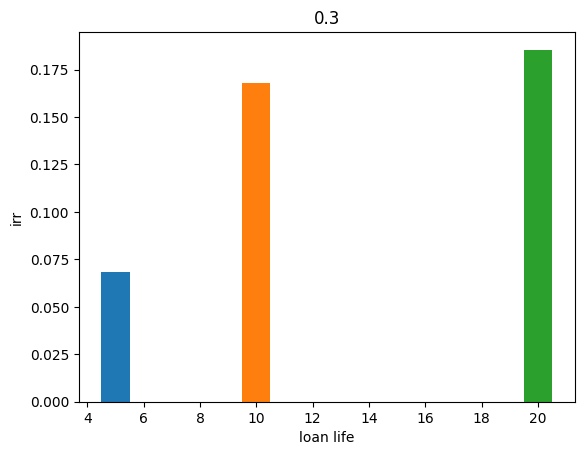

In [69]:
fig, ax = plt.subplots()

for tup in [(5, 0.3), (10, 0.3), (20, 0.3)]:
  ax.bar( tup[0], rateAvgDict[tup], width = 1)

plt.title("0.3")
plt.ylabel("irr")
plt.xlabel("loan life")

Text(0.5, 0, 'loan life')

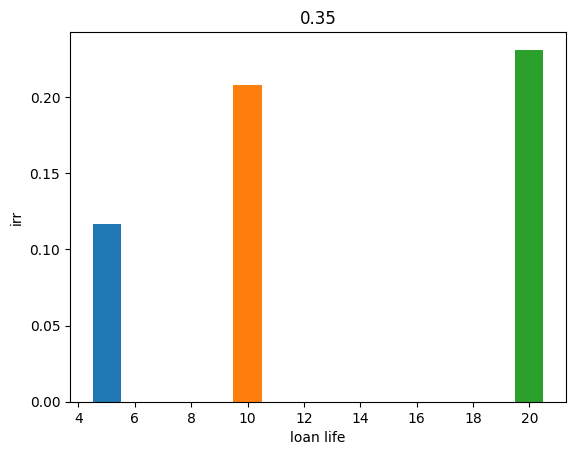

In [71]:
fig, ax = plt.subplots()

for tup in [(5, 0.35), (10, 0.35), (20, 0.35)]:
  ax.bar( tup[0], rateAvgDict[tup], width = 1)

plt.title("0.35")
plt.ylabel("irr")
plt.xlabel("loan life")

Text(0.5, 0, 'loan life')

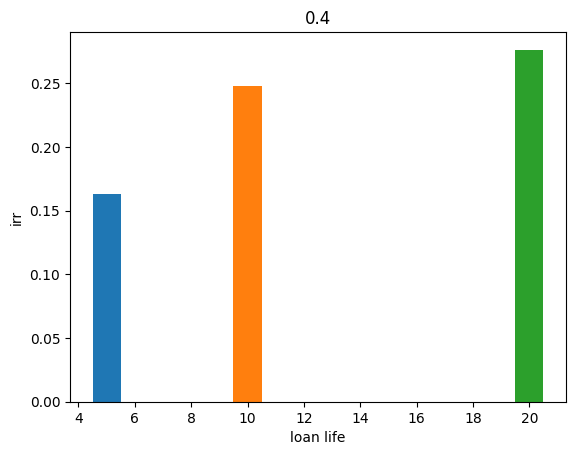

In [73]:
fig, ax = plt.subplots()

for tup in [(5, 0.4), (10, 0.4), (20, 0.4)]:
  ax.bar( tup[0], rateAvgDict[tup], width = 1)

plt.title("0.4")
plt.ylabel("irr")
plt.xlabel("loan life")

In [ ]:
# Insert your main model inbetween the inputs and output blocks

In [ ]:
# Main answer should be a DataFrame with columns of ['Interest Rate', 'Loan Life', 'Initial Default Probability', 'IRR']
# The IRR is the expected IRR across all the default cases for the interest rate,
# loan life, and initial default probability in that row
# Be sure to save this into irr_df
irr_df =